In [47]:
import numpy as np
import pandas as pd
from datetime import datetime
from time import time
import itertools
import scipy.stats as stats
from src.functions import *
import textwrap
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization, PreprocessingLayer

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score, permutation_test_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.cm as cm
import seaborn as sn
from dateutil.relativedelta import relativedelta

from sportsreference.nba.boxscore import Boxscore
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.schedule import Schedule
from sportsreference.nba.teams import Teams

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df_season = pd.read_csv('data/2nba_player_stats_by_season.csv')

/home/luke/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_season[['id', 'height', 'year', 'team_abbreviation', 'age', 'player_id']]

,id,height,year,team_abbreviation,age,player_id
0,bareajo01 2007,5-10,2007,DAL,22.500000,bareajo01
1,bareajo01 2008,5-10,2008,DAL,23.500000,bareajo01
2,bareajo01 2009,5-10,2009,DAL,24.500000,bareajo01
3,bareajo01 2010,5-10,2010,DAL,25.500000,bareajo01
4,bareajo01 2011,5-10,2011,DAL,26.500000,bareajo01
...,...,...,...,...,...,...
13230,reevekh01 1997,6-3,1997,TOT,24.416667,reevekh01
13231,reevekh01 1998,6-3,1998,DAL,25.416667,reevekh01
13232,reevekh01 1999,6-3,1999,DET,26.416667,reevekh01
13233,reevekh01 2000,6-3,2000,CHI,27.416667,reevekh01


# Dropping Columns

In [4]:
drop_lst = []

for col in df_season.columns:
    unique = df_season[col].unique()
    val = len(unique)
    if val <= 1:
        drop_lst.append(str(col))
        print(f'{col}: has {val} values')
        print(f'Values include:')
        print(f'     {unique}')

print(f'Drop List: {drop_lst}')

and_ones: has 1 values
Values include:
     [nan]
blocking_fouls: has 1 values
Values include:
     [nan]
center_percentage: has 1 values
Values include:
     [0]
dunks: has 1 values
Values include:
     [nan]
lost_ball_turnovers: has 1 values
Values include:
     [nan]
net_plus_minus: has 1 values
Values include:
     [nan]
offensive_fouls: has 1 values
Values include:
     [nan]
on_court_plus_minus: has 1 values
Values include:
     [nan]
other_turnovers: has 1 values
Values include:
     [nan]
passing_turnovers: has 1 values
Values include:
     [nan]
percentage_field_goals_as_dunks: has 1 values
Values include:
     [nan]
percentage_of_three_pointers_from_corner: has 1 values
Values include:
     [nan]
percentage_shots_three_pointers: has 1 values
Values include:
     [nan]
percentage_shots_two_pointers: has 1 values
Values include:
     [nan]
point_guard_percentage: has 1 values
Values include:
     [0]
points_generated_by_assists: has 1 values
Values include:
     [nan]
power_for

In [5]:
df_season = df_season.drop(drop_lst, axis=1)
df_season = df_season.drop('id', axis=1)

# Row work

In [6]:
def to_inches(height):
    feet, inches = str(height).split('-')
    return (int(feet)*12) + int(inches)

In [7]:
df_season['height'] = df_season['height'].apply(to_inches)

In [8]:
player_names = df_season['name'].unique()
type(player_names)

numpy.ndarray

# Filling NaN's

In [9]:
# Making copy of df_season and going to continue working with that one in place (13235 rows)
df_copy = df_season.copy()

In [10]:
# Players in season df that were paid but did not play
df_paid_not_played = df_season[df_season['minutes_played'].isna()]

# removed 658 rows reduced to 12577 after removing players that did not play (don't want to skew data)
df_season = df_season.drop(df_paid_not_played.index)

In [11]:
# Removed 1072 down to 11495
# Some players don't have a recorded salary, going to seperate those out to their own df
df_season = df_season[df_season['salary'] >= 100]

In [12]:
# Filling nan for position with 'na' & then the rest of the categories with 0's
# because they're only nan's since they haven't attempted
df_season['position'] = df_season['position'].fillna('na')

In [13]:
# Creating current/past players DF's & then dropping the columns that only pertain to current players from career_df
df_past_players = df_season[df_season['current_player'] == False]
#df_past_players
df_current_players = df_season[df_season['current_player'] == True]
#df_current_players
current_player_features = ['contract_total', 'contract_length', 'current_salary', 'current_avg_salary', 'current_team']
df_season = df_season.drop(current_player_features, axis=1)

In [14]:
# Filling nans with 0's since the rest mean that nothing was attempted from what I could tell
df_season = df_season.fillna(0)

In [15]:
non_stats = ['salary', 'year','nationality', 'position', 'birth_date', 'year_list', 'team_abbreviation', 'player_id', 'name', 'salary']

df_pure_stats = df_season.drop(non_stats, axis=1)

In [16]:
df_pure_stats.shape

(11495, 62)

In [17]:
df_pure_stats = df_pure_stats.astype('float64')

# Sanity Check

In [18]:
df_pure_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11495 entries, 0 to 13234
Data columns (total 62 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   assist_percentage                               11495 non-null  float64
 1   assists                                         11495 non-null  float64
 2   block_percentage                                11495 non-null  float64
 3   blocks                                          11495 non-null  float64
 4   box_plus_minus                                  11495 non-null  float64
 5   defensive_box_plus_minus                        11495 non-null  float64
 6   defensive_rebound_percentage                    11495 non-null  float64
 7   defensive_rebounds                              11495 non-null  float64
 8   defensive_win_shares                            11495 non-null  float64
 9   effective_field_goal_percentage        

# Exploratory Graphs

In [19]:
#sn.pairplot(df_pure_stats)

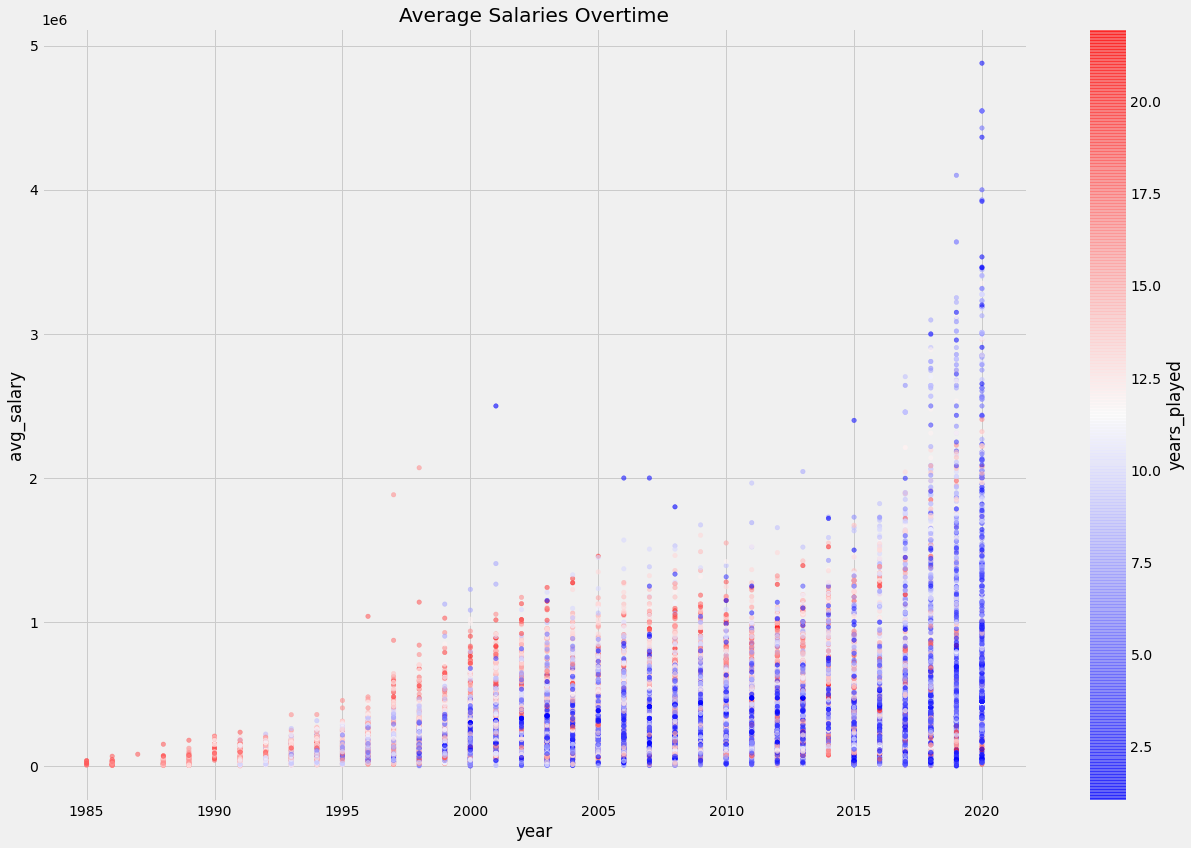

In [20]:
df_season.plot(kind="scatter", x="year", y="avg_salary", alpha=0.6, figsize=(18,12),
             c="years_played", cmap=plt.get_cmap("bwr"), colorbar=True,
             title='Average Salaries Overtime')

plt.tight_layout()
plt.savefig('images/avg_salaries_overtime.png')

# Looking for correlations

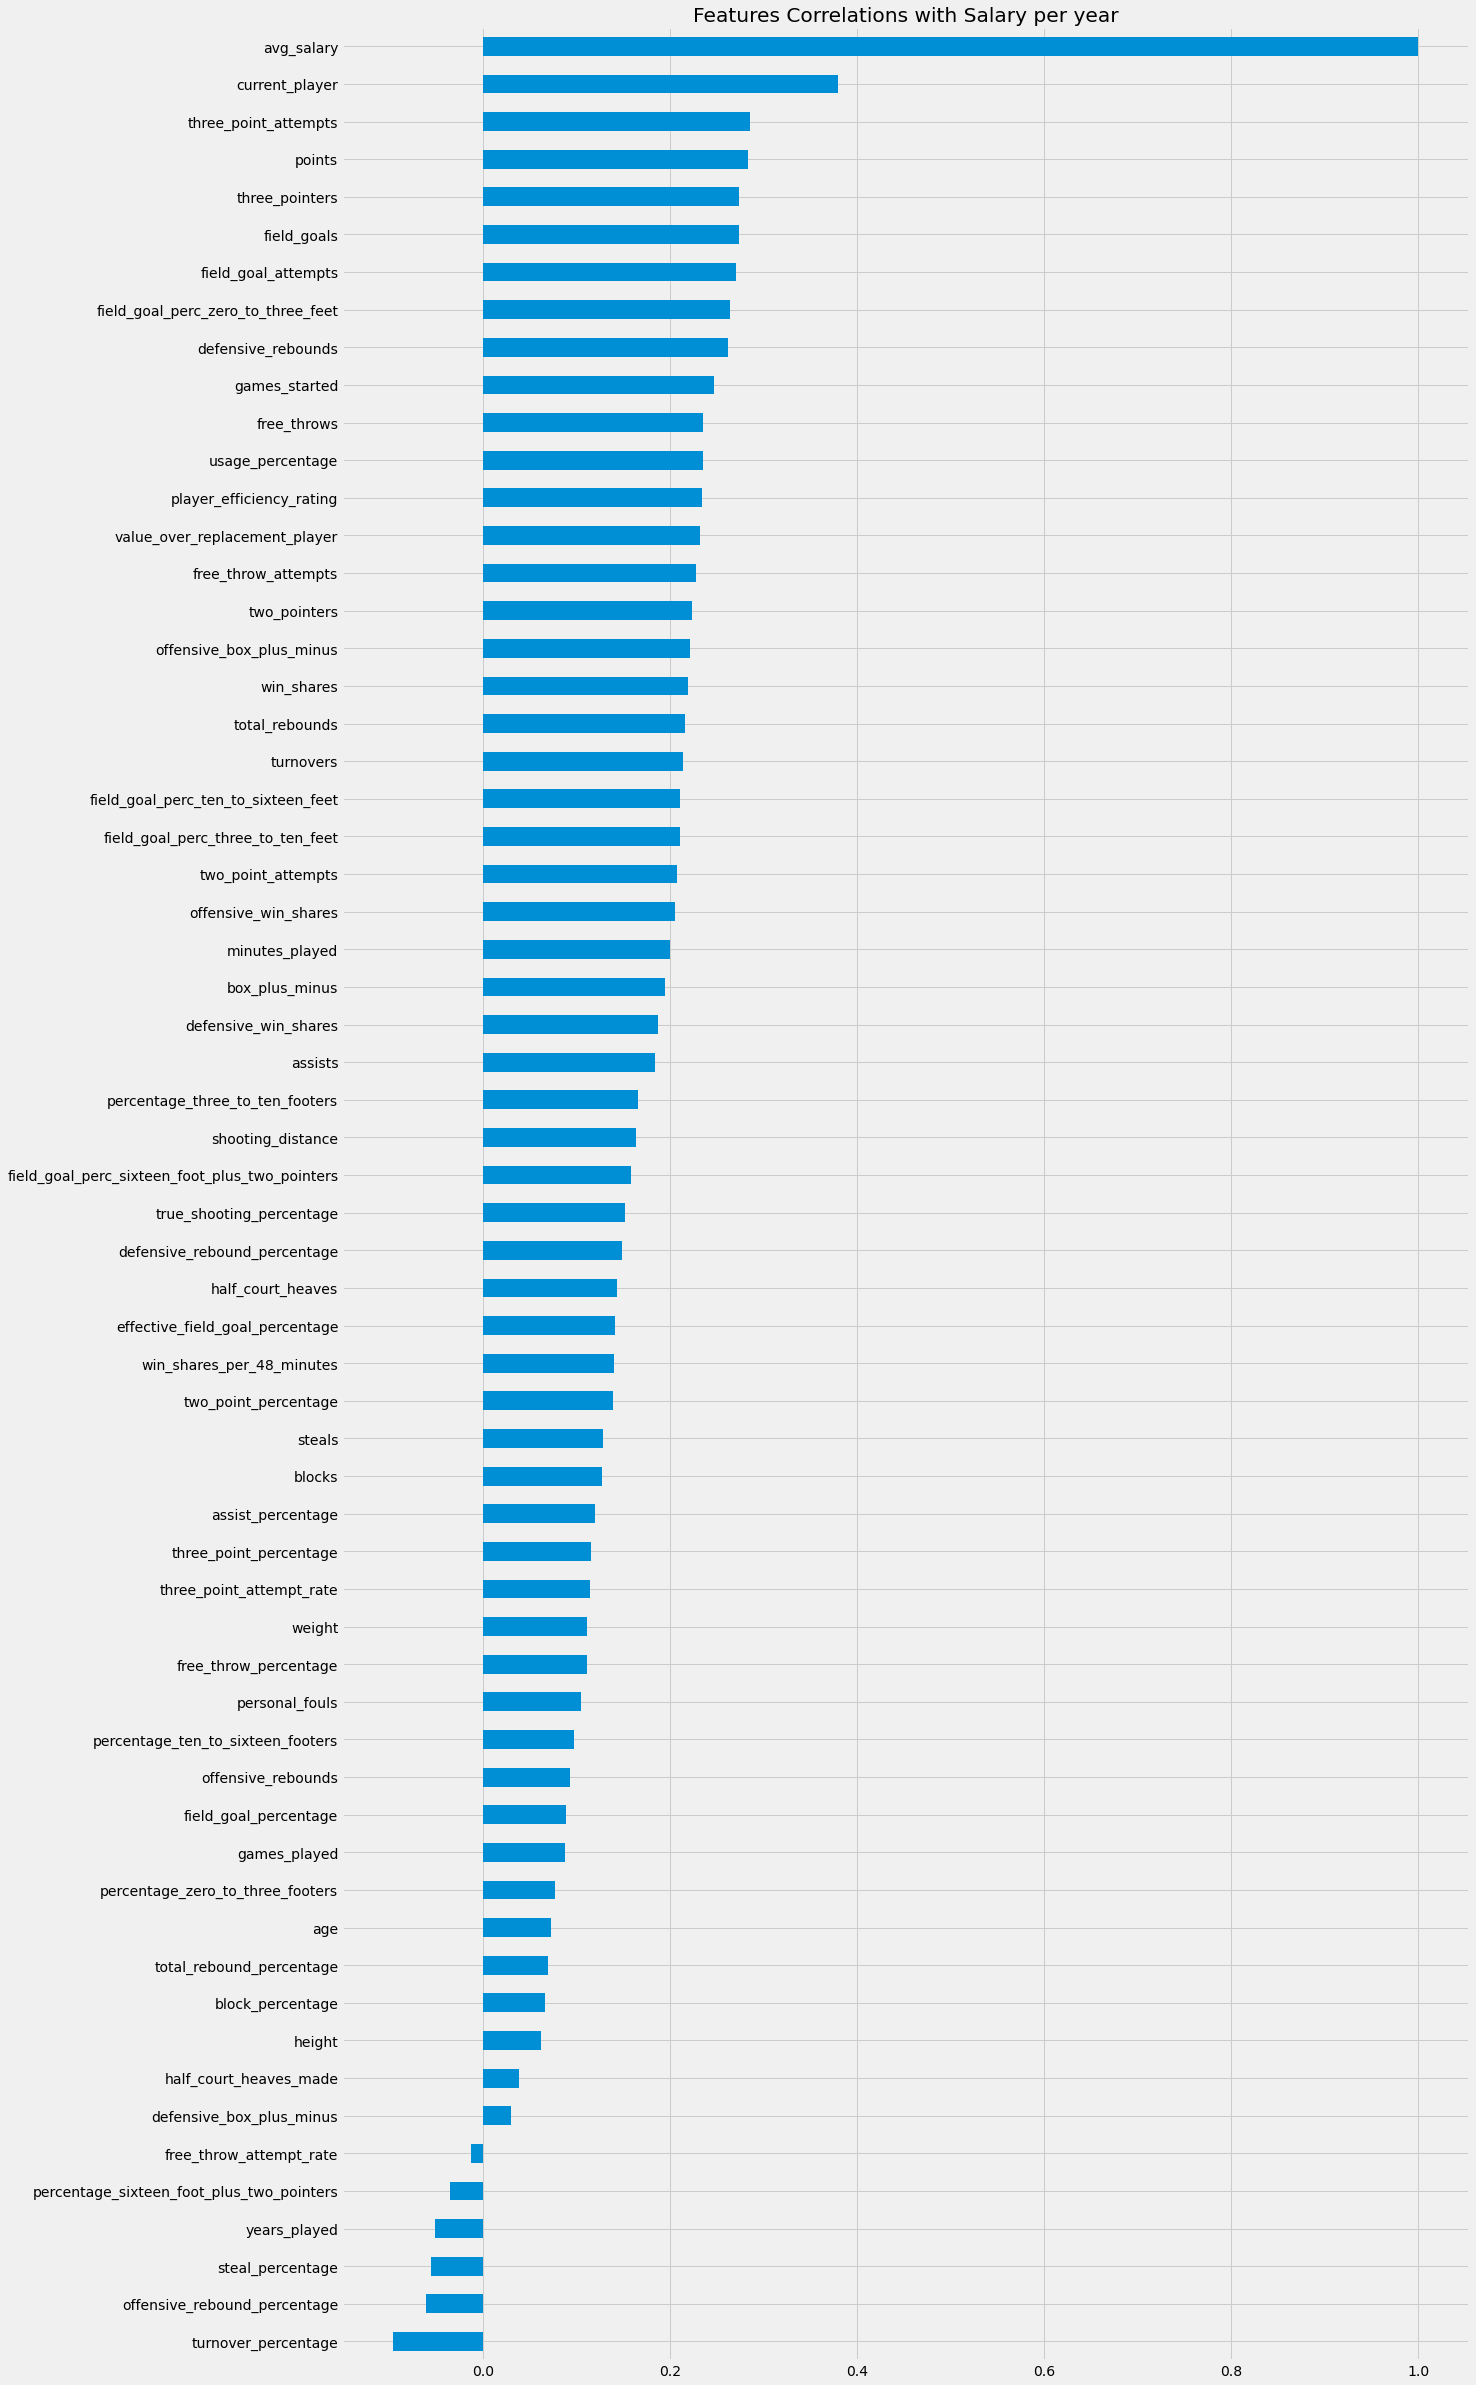

In [21]:
corr_matrix = df_pure_stats.corr()
corr_matrix['avg_salary'].sort_values(ascending=True).plot(title='Features Correlations with Salary per year', kind='barh', figsize=(18,40))
plt.savefig('images/feature_correlation.png')

In [22]:
df_pure_stats.shape

(11495, 62)

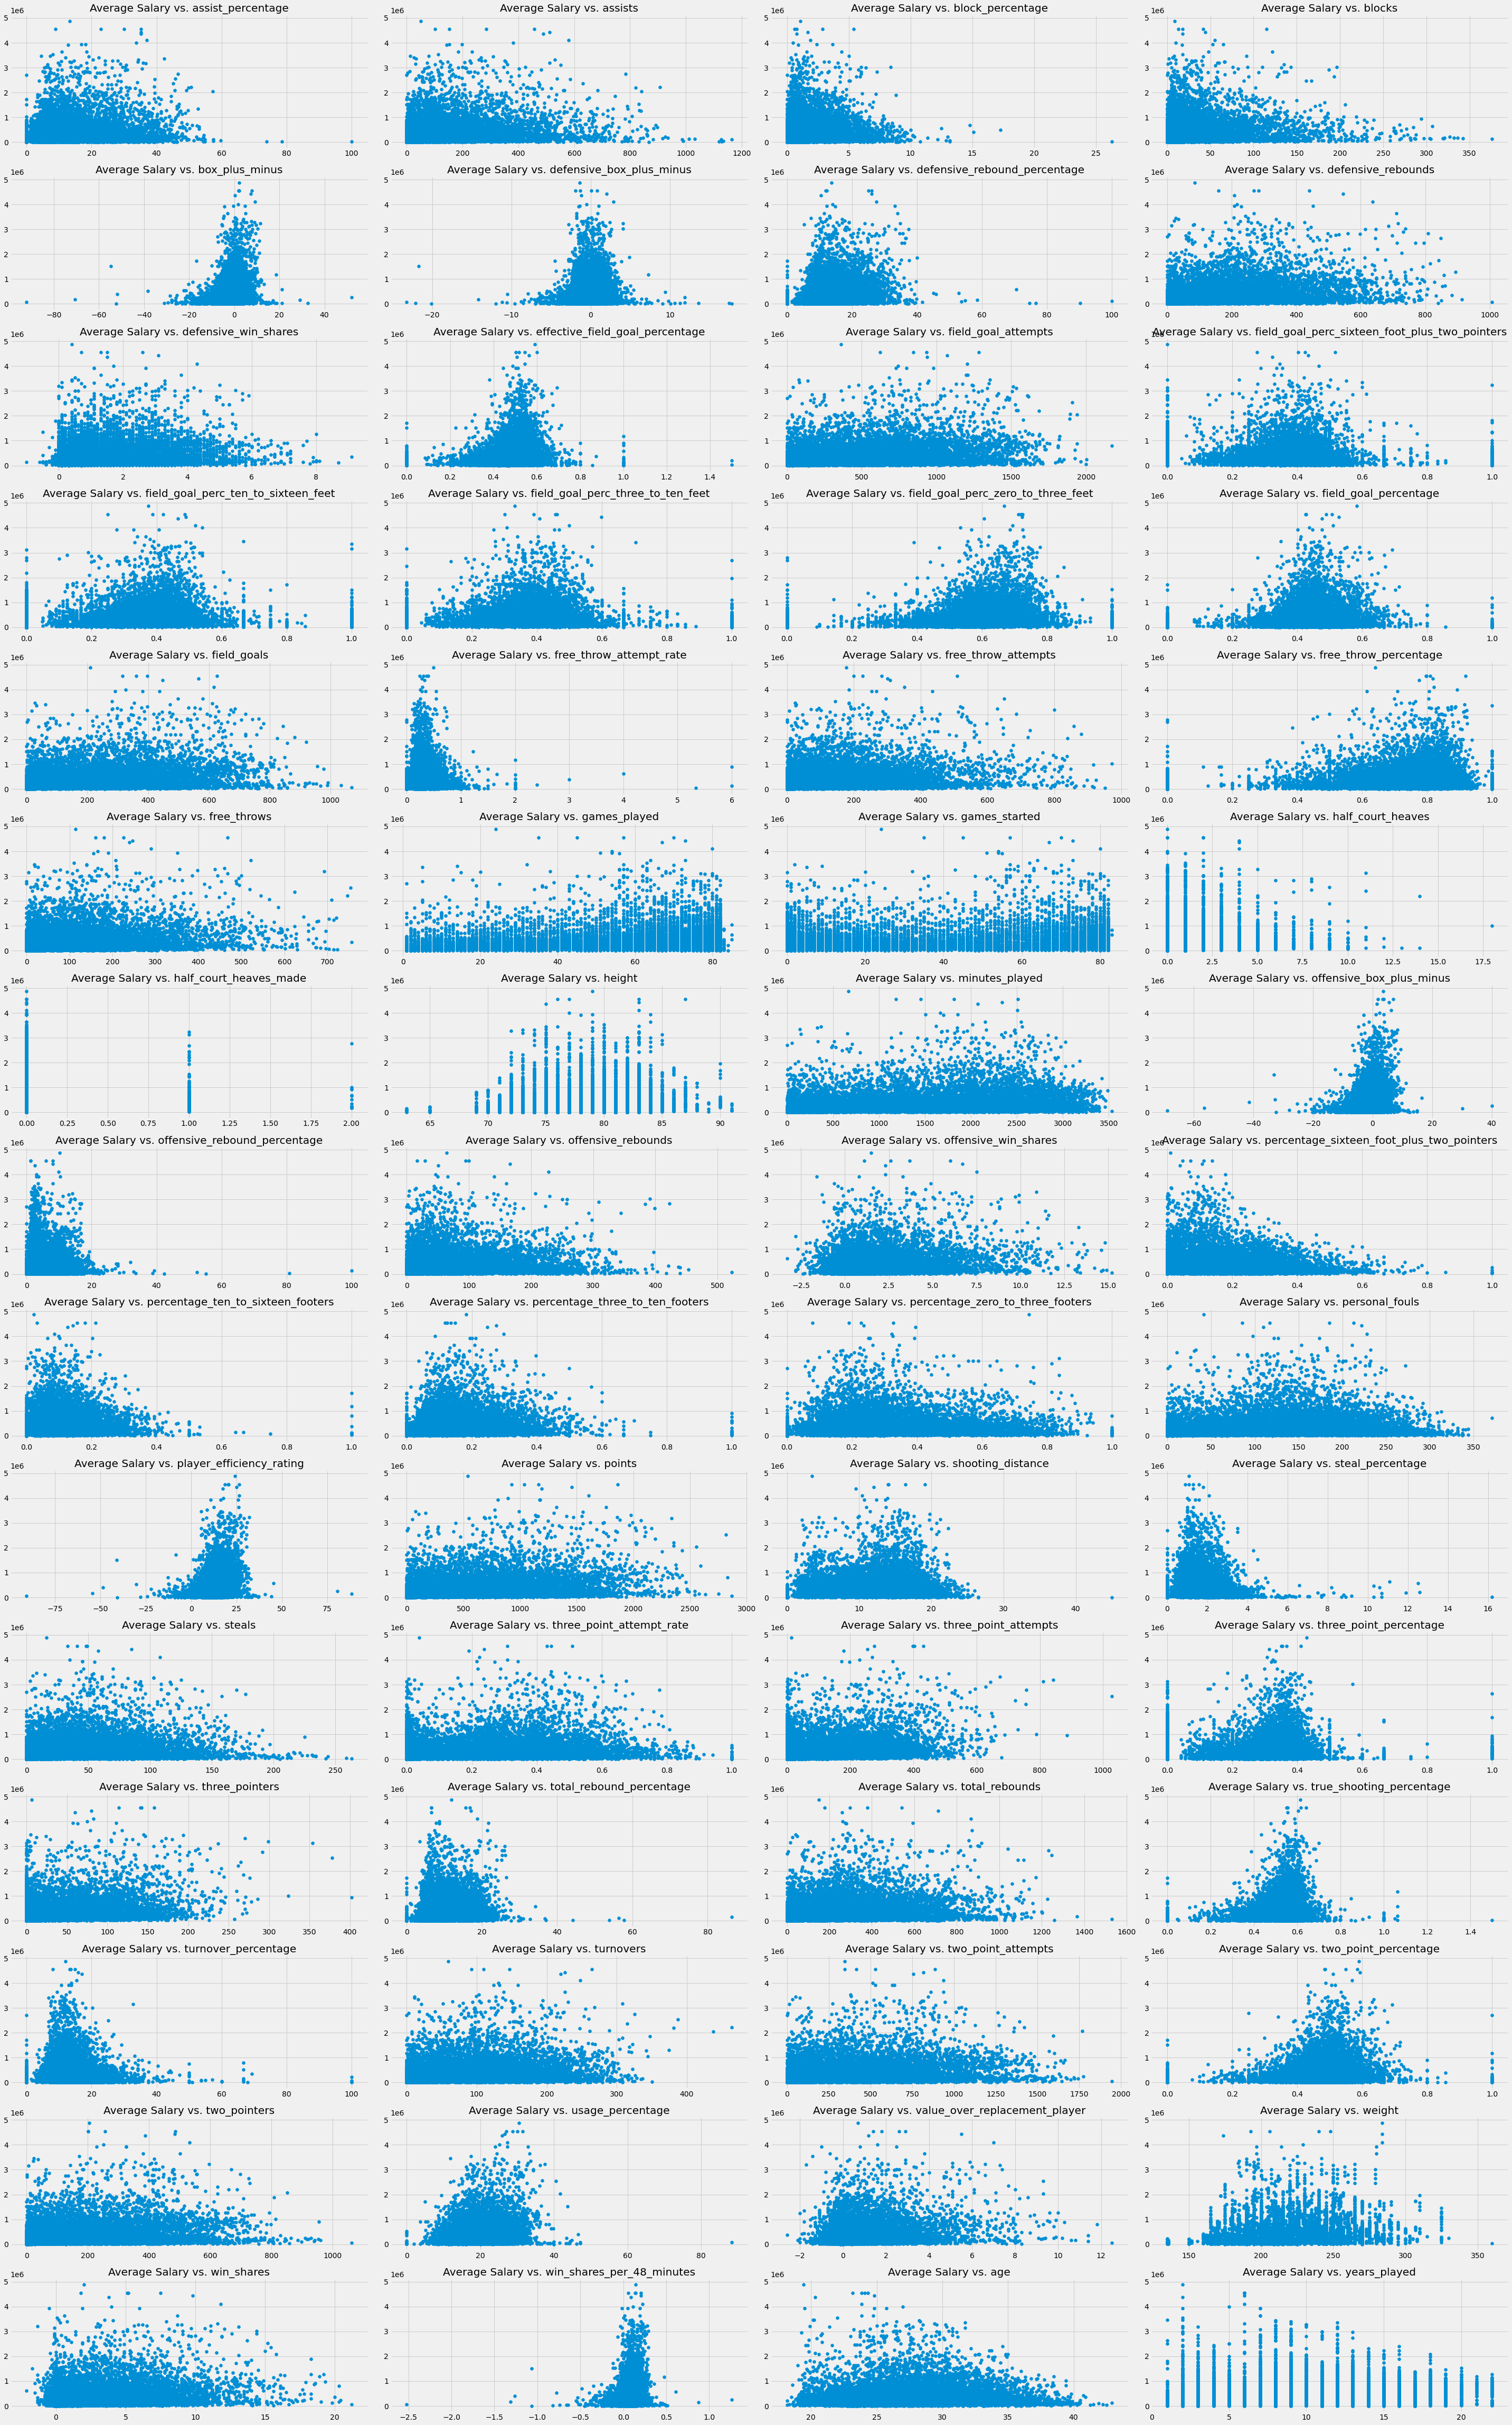

In [23]:
fig, axs = plt.subplots(15, 4, figsize = (40, 64))

for ax, col in zip(axs.flatten(), df_pure_stats.drop(['avg_salary', 'current_player'], axis=1).columns):
    ax.scatter(df_pure_stats[col], df_pure_stats['avg_salary'])
    ax.set_title(f'Average Salary vs. {col}')
    
fig.tight_layout()
plt.savefig('images/scattermatrix.png')

# Train_test_splitting

In [52]:
y = df_pure_stats['avg_salary']
X = df_pure_stats.drop('avg_salary', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
salary_median = np.median(y_train)
salary_median

253991.72727272726

In [27]:
salary_mean = np.mean(y_train)
salary_mean

403299.6134988168

In [28]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              314.7
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                        0.00
Time:                        21:35:05   Log-Likelihood:                     -1.3067e+05
No. Observations:                9196   AIC:                                  2.614e+05
Df Residuals:                    9139   BIC:                                  2.619e+05
Df Model:                          57                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Linear Regression

## Training

In [29]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [30]:
salary_predictions = lin_model.predict(X_train)

In [31]:
print("Mean absolute error =", round(mean_absolute_error(y_train, salary_predictions), 2)) 
print("Mean squared error =", round(mean_squared_error(y_train, salary_predictions), 2)) 
print("Median absolute error =", round(median_absolute_error(y_train, salary_predictions), 2)) 
print("Explain variance score =", round(explained_variance_score(y_train, salary_predictions), 2)) 
print("R2 score =", round(r2_score(y_train, salary_predictions), 2))

Mean absolute error = 239171.55
Mean squared error = 127281566663.04
Median absolute error = 172335.09
Explain variance score = 0.42
R2 score = 0.42


In [32]:
residuals = salary_predictions - y_train

In [33]:
np.median(residuals)

43939.5018503851

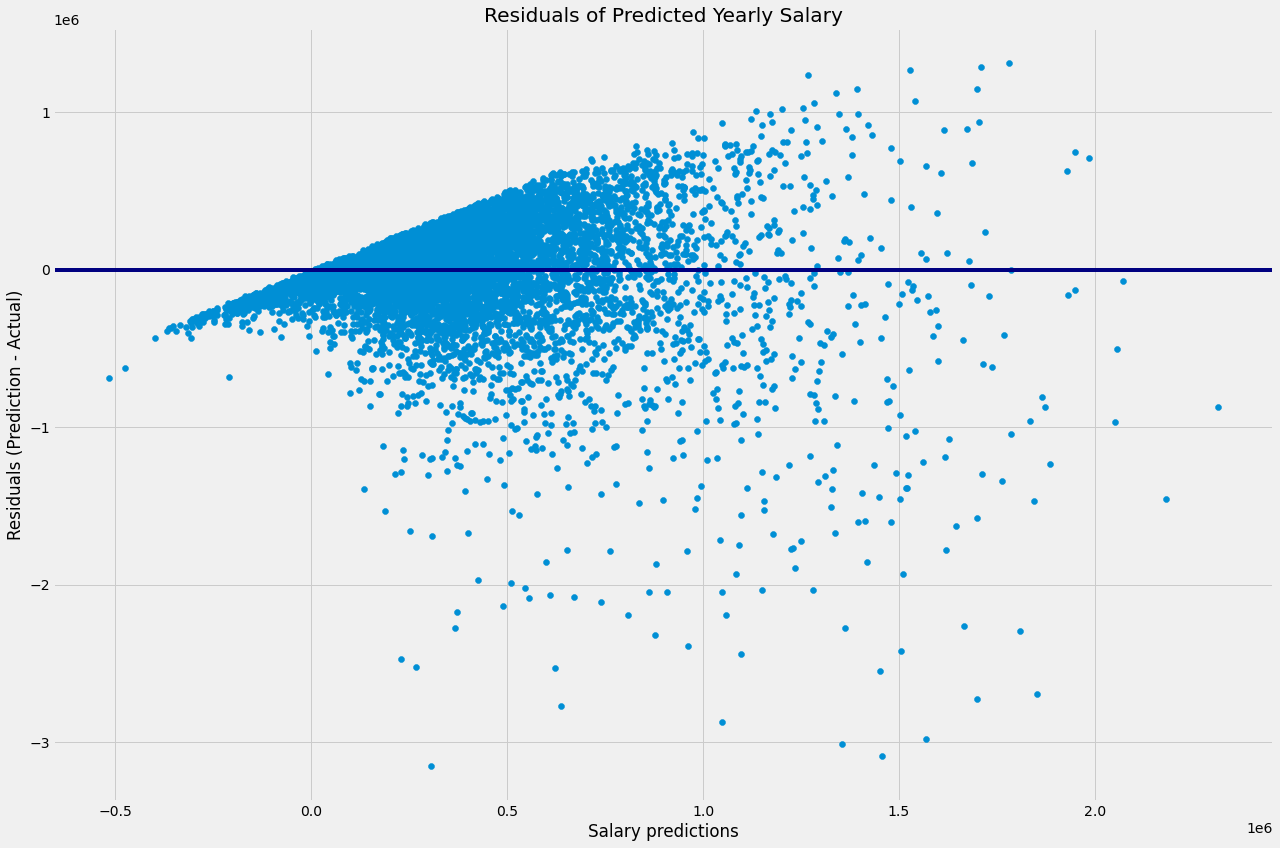

In [34]:
fig, ax = plt.subplots(figsize = (18,12))

ax.scatter(salary_predictions, residuals)
ax.axhline(0, color = 'navy')

ax.set_ylabel('Residuals (Prediction - Actual)')
ax.set_xlabel('Salary predictions')
ax.set_title('Residuals of Predicted Yearly Salary')

plt.tight_layout()
plt.savefig('images/residuals_train.png');

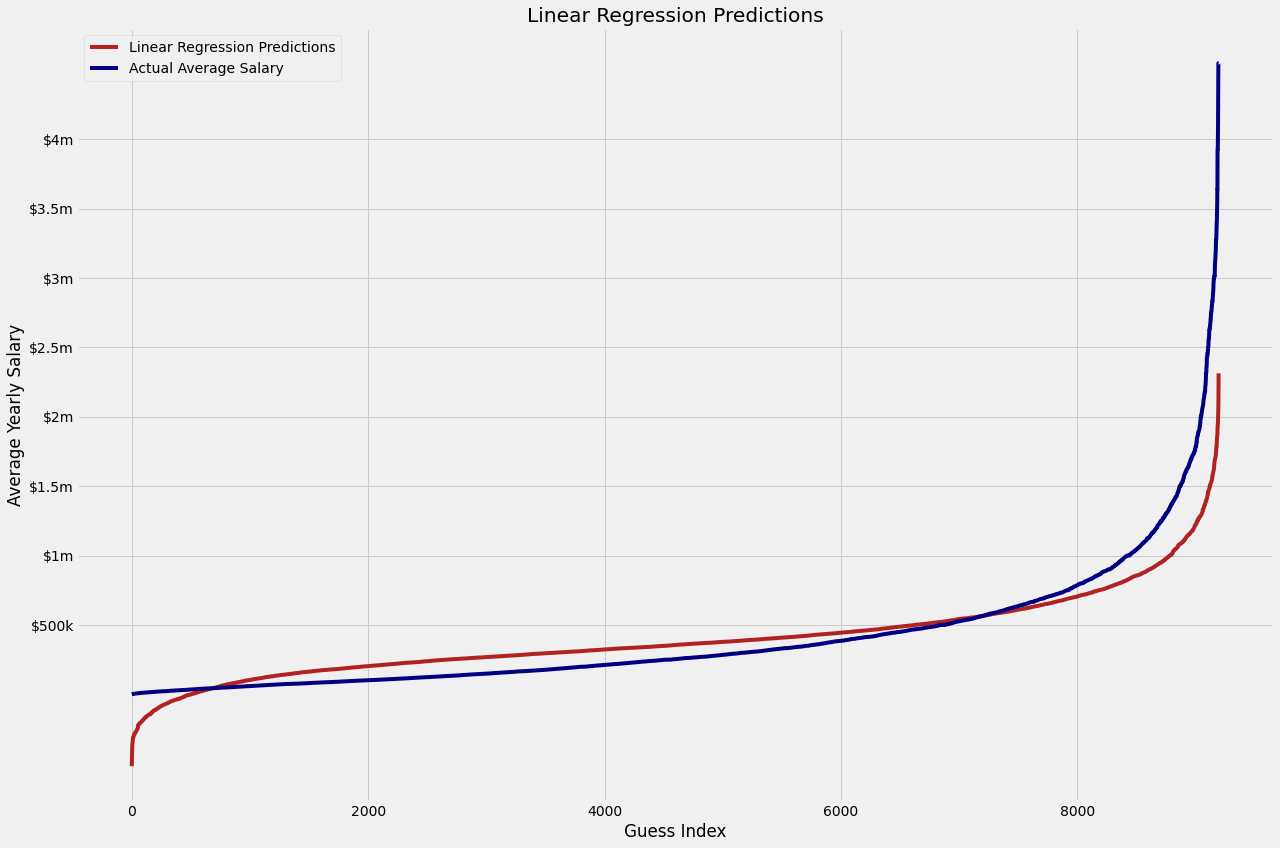

In [35]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(np.sort(salary_predictions), label='Linear Regression Predictions', c='firebrick')
ax.plot(np.sort(y_train), label='Actual Average Salary', c='navy')
#ax.axhline(lin_rmse, linestyle='--', label='RMSE',c='tomato')
#ax.axhline(salary_median, linestyle='--', label='Actual Median', c='deepskyblue')
ax.set_yticks(ticks=[500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000])
ax.set_yticklabels(['$500k','$1m','$1.5m','$2m','$2.5m','$3m','$3.5m', '$4m'])
ax.set_ylabel('Average Yearly Salary')
ax.set_xlabel('Guess Index')
ax.set_title('Linear Regression Predictions')

plt.tight_layout()
plt.legend()
plt.savefig('images/linear_regression.png');

## Test Set

# Neural Networkings

In [53]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
X_train_full.shape

(8621, 61)

### Creating Pre-Processing Layer

In [75]:
normalizer = Normalization()
normalizer.adapt(np.array(X_train_full))

In [87]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [88]:
linear_model.predict(X_train_full[:10])

array([[ 0.06290659],
       [ 1.1456593 ],
       [-0.02735139],
       [-0.91859293],
       [-2.1153886 ],
       [-0.00984608],
       [-2.3587532 ],
       [ 1.1264867 ],
       [-1.9506238 ],
       [-2.9992077 ]], dtype=float32)

In [89]:
linear_model.layers[1].kernel

<tf.Variable 'dense_9/kernel:0' shape=(61, 1) dtype=float32, numpy=
array([[-0.23157036],
       [ 0.22541332],
       [-0.05249074],
       [-0.24869002],
       [ 0.06709275],
       [ 0.18075421],
       [-0.2733301 ],
       [ 0.22195733],
       [ 0.13688552],
       [ 0.11201775],
       [-0.11323056],
       [ 0.25852358],
       [ 0.3006537 ],
       [ 0.2794168 ],
       [ 0.26609695],
       [-0.04577172],
       [-0.20802325],
       [-0.27394953],
       [-0.24791527],
       [-0.09434056],
       [-0.31107894],
       [ 0.03358769],
       [-0.30458012],
       [-0.20521872],
       [ 0.02178901],
       [-0.28908297],
       [-0.27927715],
       [-0.09487325],
       [-0.05117008],
       [-0.02073723],
       [ 0.26308072],
       [ 0.09245393],
       [-0.07177907],
       [ 0.1574271 ],
       [ 0.25985092],
       [ 0.04403669],
       [-0.2507674 ],
       [-0.02580452],
       [-0.14135112],
       [ 0.13613811],
       [ 0.11507654],
       [ 0.27771276],
       [

In [91]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mae', 'mse'])

In [93]:
%%time
history = linear_model.fit(
    X_train_full, y_train_full, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
216/216 [==============================] - 1s 1ms/step - loss: 406251.3353 - mae: 406251.3353 - mse: 380992498900.3502 - val_loss: 397879.4688 - val_mae: 397879.4688 - val_mse: 377799671808.0000
Epoch 2/100
216/216 [==============================] - 0s 949us/step - loss: 400828.8445 - mae: 400828.8445 - mse: 360110646644.7926 - val_loss: 397858.7500 - val_mae: 397858.7500 - val_mse: 377780895744.0000
Epoch 3/100
216/216 [==============================] - 0s 1ms/step - loss: 402181.1538 - mae: 402181.1538 - mse: 378550856991.8525 - val_loss: 397838.0938 - val_mae: 397838.0938 - val_mse: 377763758080.0000
Epoch 4/100
216/216 [==============================] - 0s 967us/step - loss: 407022.0202 - mae: 407022.0202 - mse: 389527890023.8157 - val_loss: 397817.4688 - val_mae: 397817.4688 - val_mse: 377743343616.0000
Epoch 5/100
216/216 [==============================] - 0s 896us/step - loss: 403054.9011 - mae: 403054.9011 - mse: 377038447762.2857 - val_loss: 397796.7188 - val_mae: 

216/216 [==============================] - 0s 1ms/step - loss: 401775.0288 - mae: 401775.0288 - mse: 380793144730.5438 - val_loss: 396266.6562 - val_mae: 396266.6562 - val_mse: 376335892480.0000
Epoch 80/100
216/216 [==============================] - 0s 931us/step - loss: 412869.4844 - mae: 412869.4844 - mse: 403670770985.2903 - val_loss: 396246.0312 - val_mae: 396246.0312 - val_mse: 376316297216.0000
Epoch 81/100
216/216 [==============================] - 0s 943us/step - loss: 404177.7910 - mae: 404177.7910 - mse: 379166256189.3456 - val_loss: 396225.2500 - val_mae: 396225.2500 - val_mse: 376298569728.0000
Epoch 82/100
216/216 [==============================] - 0s 941us/step - loss: 406179.3829 - mae: 406179.3829 - mse: 388147124271.1890 - val_loss: 396204.4375 - val_mae: 396204.4375 - val_mse: 376277336064.0000
Epoch 83/100
216/216 [==============================] - 0s 1ms/step - loss: 404494.8236 - mae: 404494.8236 - mse: 378762361067.9447 - val_loss: 396184.0000 - val_mae: 396184.0

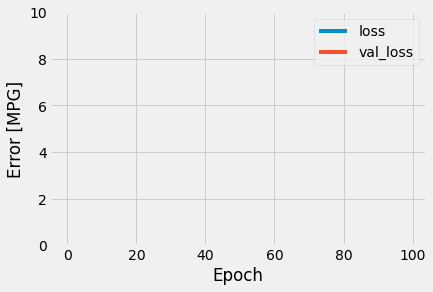

In [94]:
plot_loss(history)

In [76]:
first = np.array(X_train_full[:20])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[  5.5   53.     1.3  ...  27.5   10.     0.  ]
 [ 21.   246.     0.5  ...  23.58   9.     0.  ]
 [ 31.8  305.     0.8  ...  27.08  16.     0.  ]
 ...
 [  7.2  104.     1.4  ...  30.75  13.     0.  ]
 [  6.1   57.     2.7  ...  23.     7.     0.  ]
 [ 17.1   15.     0.   ...  22.     1.     0.  ]]

Normalized: [[-0.81 -0.52 -0.2  ...  0.11 -0.12 -0.46]
 [ 0.83  0.85 -0.67 ... -0.83 -0.34 -0.46]
 [ 1.97  1.27 -0.49 ...  0.01  1.15 -0.46]
 ...
 [-0.63 -0.15 -0.14 ...  0.89  0.51 -0.46]
 [-0.75 -0.49  0.63 ... -0.97 -0.76 -0.46]
 [ 0.42 -0.79 -0.97 ... -1.21 -2.03 -0.46]]


In [85]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [77]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', input_shape=[X_train_full.shape[1]]),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001), 
                metrics=['mae', 'mse'])
  return model

In [78]:
model = build_and_compile_model(normalizer)

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 61)                123       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                3968      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 8,316
Trainable params: 8,193
Non-trainable params: 123
_________________________________________________________________


In [84]:
%%time
history = model.fit(
    X_train_full['points'], y_train_full,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 33.7 s, sys: 4.88 s, total: 38.6 s
Wall time: 20 s


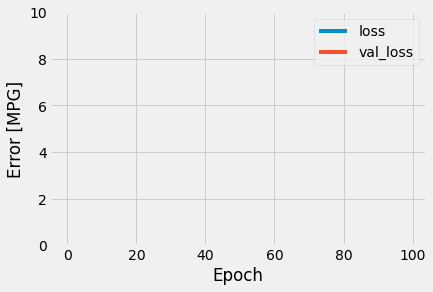

In [86]:
plot_loss(history)

In [ ]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[0, 61]),
    keras.layers.Dense(1)
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid))

In [ ]:
'''Trains a simple convnet on the MNIST dataset.
based on a keras example by fchollet
Find a way to improve the test accuracy to almost 99%!
FYI, the number of layers and what they do is fine.
But their parameters and other hyperparameters could use some work.
'''
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
np.random.seed(1337)  # for reproducibility

def load_and_featurize_data():
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = train_test_split(X.values, y.values)

    # reshape input into format Conv2D layer likes
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

    # don't change conversion or normalization
    X_train = X_train.astype('float32')  # data was uint8 [0-255]
    X_test = X_test.astype('float32')    # data was uint8 [0-255]
    X_train /= 255  # normalizing (scaling from 0 to 1)
    X_test /= 255   # normalizing (scaling from 0 to 1)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices (don't change)
    Y_train = to_categorical(y_train, nb_classes)  # cool
    Y_test = to_categorical(y_test, nb_classes)
    
    # in Ipython you should compare Y_test to y_test
    return X_train, X_test, Y_train, Y_test


def define_model(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid',
                     input_shape=input_shape))  # first conv. layer  KEEP
    
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid'))  # 2nd conv. layer KEEP
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting
    
    # Adding another layer
    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid',
                     input_shape=input_shape))  # first conv. layer  KEEP
    
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     padding='valid'))  # 2nd conv. layer KEEP
    
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(32))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.3))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('softmax'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


if __name__ == '__main__':
    # important inputs to the model: don't changes the ones marked KEEP
    img_rows, img_cols = 28, 28   # the size of the MNIST images KEEP
    input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
    nb_classes = 10    # number of output possibilities: [0 - 9] KEEP
    
    batch_size = 32  # number of training samples used at a time to update the weights
    nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
    nb_filters = 32    # number of convolutional filters to use
    pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
    kernel_size = (3, 3)  # convolutional kernel size, slides over image to learn features

    X_train, X_test, Y_train, Y_test = load_and_featurize_data()

    model = define_model(nb_filters, kernel_size, input_shape, pool_size)

    # during fit process watch train and test error simultaneously
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))

    score = model.evaluate(X_test, Y_test, verbose=0)
    
    print('Test score:', score[0])
    print('Test accuracy:', score[1])  # this is the one we care about

# Cross validation

In [ ]:
X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2)

In [ ]:
cv_test_scores = []
cv_train_scores = []

for n in range(1000,9000, 100):
    cv_test, cv_train = my_cross_val_scores(X_train[:n], y_train[:n], num_folds=5)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(cv_test_scores, label='test rmse')
ax.plot(cv_train_scores, label='train rmse')
#ax.axvline(np.min(cv_test_scores), c='r', linestyle='--')
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('average rmse vs # of folds k')

ax.legend();

In [ ]:
cv_test_scores = []
cv_train_scores = []

for k in range(2,51):
    cv_test, cv_train = my_cross_val_scores(X_train, y_train, num_folds=k)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))

ax.plot(cv_test_scores, label='test rmse')
ax.plot(cv_train_scores, label='train rmse')
#ax.axvline(np.min(cv_test_scores), c='r', linestyle='--')
ax.set_xlabel('k')
ax.set_ylabel('rmse')
ax.set_title('average rmse vs # of folds k')

ax.legend();

In [ ]:
lin_scores = cross_val_score(lin_model, season, season_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(season, season_labels)